# IMPORT LIBRARIES

In [1]:
import matplotlib as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas import Series, DataFrame
from patsy import dmatrices

%matplotlib inline

C:\Users\David\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# US ANALYSIS

In [2]:
# Hardcoded Values
us_median_income = 55322 # from DP03 table
us_unemployment_rate = 4.6

In [3]:
us_demresults = pd.read_csv('CleanedDemPrimaryResults.csv')
us_econ = pd.read_csv('usecondp03.csv', encoding='latin-1')
us_social = pd.read_csv('ussocialdp02.csv', encoding='latin-1')

C:\Users\David\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (61,62,69,70,275,276,367,368,375,376,441,442,445,446,449,450,453,454,481,482,485,486,493,494,497,498,501,502,505,506,517,518,521,522,525,526,529,530) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\David\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (68,96,120,143,144,145,147,148,149,150,151,152,155,156,159,160,163,164,167,168,177,178,181,182,185,186,189,190,193,194,232,377,378,381,382,405,406,409,410,417,418,421,422,425,426,429,430,433,434,437,438) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
desired_columns_econ = ['Id','Id2','Geography',
                   'Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate',
                  'Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)',
                  'Percent; INDUSTRY - Civilian employed population 16 years and over - Agriculture, forestry, fishing and hunting, and mining',
                   'Percent; INDUSTRY - Civilian employed population 16 years and over - Construction',
                   'Percent; INDUSTRY - Civilian employed population 16 years and over - Manufacturing',
                   'Percent; INDUSTRY - Civilian employed population 16 years and over - Transportation and warehousing, and utilities',
                   'Percent; INDUSTRY - Civilian employed population 16 years and over - Educational services, and health care and social assistance',
                   'Percent; INDUSTRY - Civilian employed population 16 years and over - Public administration',
                   'Percent; INDUSTRY - Civilian employed population 16 years and over - Information',
                   'Percent; INDUSTRY - Civilian employed population 16 years and over - Finance and insurance, and real estate and rental and leasing',
                   'Percent; INDUSTRY - Civilian employed population 16 years and over - Professional, scientific, and management, and administrative and waste management services',
                    ]
us_econ = us_econ[desired_columns_econ]

desired_columns_social = ['Id','Id2','Geography',
                          'Percent; PLACE OF BIRTH - Total population - Foreign born',
                         'Percent; EDUCATIONAL ATTAINMENT - Percent high school graduate or higher',
                         'Percent; EDUCATIONAL ATTAINMENT - Percent bachelors degree or higher']
us_social = us_social[desired_columns_social]

In [5]:
# Merge social data & economic data
us_countydata = us_econ.merge(us_social)


In [6]:
# Filters out irrelevant counties from us_countydata
all_counties = us_countydata['Id2']
relevant_counties = us_demresults['fips']

k = all_counties.isin(relevant_counties)

us_countydata = us_countydata[k]

# Ensure shapes aligned
print(us_countydata.shape,us_demresults.shape)

(1077, 17) (1077, 10)


In [7]:
# Merge demographic data and primary results
us_dataset = us_demresults.merge(us_countydata, left_on='fips',right_on='Id2', how='outer')

In [8]:
# Drop duplicate columns from merged dataset
us_dataset = us_dataset.drop('Id',1)
us_dataset = us_dataset.drop('Id2',1)
us_dataset = us_dataset.drop('Geography',1)

In [9]:
# Feature engineering

# Job type baskets
us_dataset['bluecollarjobpct'] = (us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Agriculture, forestry, fishing and hunting, and mining'] + 
                                us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Construction'] + 
                                us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Manufacturing'] +
                                us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Transportation and warehousing, and utilities'])

us_dataset['publicjobpct'] = (us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Educational services, and health care and social assistance'] + 
                            us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Public administration'])

us_dataset['whitecollarjobpct'] = (us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Information'] + 
                                us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Finance and insurance, and real estate and rental and leasing'] + 
                                us_dataset['Percent; INDUSTRY - Civilian employed population 16 years and over - Professional, scientific, and management, and administrative and waste management services'])

# Median income % national average
us_dataset['medianincomepctaverage'] = us_dataset['Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)']/us_median_income

# US Unemployment Diff
us_dataset['UnemploymentDiff'] = us_dataset['Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate']-us_unemployment_rate

In [10]:
#Preview dataframe
us_dataset

,state,state_abbreviation,county,fips,Bernie Vote,Bernie %,Hillary Vote,Hillary %,1 if Bernie Won,Margin,...,"Percent; INDUSTRY - Civilian employed population 16 years and over - Finance and insurance, and real estate and rental and leasing","Percent; INDUSTRY - Civilian employed population 16 years and over - Professional, scientific, and management, and administrative and waste management services",Percent; PLACE OF BIRTH - Total population - Foreign born,Percent; EDUCATIONAL ATTAINMENT - Percent high school graduate or higher,Percent; EDUCATIONAL ATTAINMENT - Percent bachelors degree or higher,bluecollarjobpct,publicjobpct,whitecollarjobpct,medianincomepctaverage,UnemploymentDiff
0,Connecticut,CT,Tolland County,9013,8734,0.608472,5620,0.391528,1,0.216943,...,8.8,9.3,6.8,93.8,38.9,22.1,32.9,19.8,1.448411,1.7
1,Connecticut,CT,Windham County,9015,5555,0.598406,3728,0.401594,1,0.196811,...,4.4,7.9,5.3,88.1,23.9,24.9,31.1,13.9,1.097014,3.8
2,Connecticut,CT,Litchfield County,9005,9186,0.570099,6927,0.429901,1,0.140197,...,7.1,9.6,7.5,91.7,34.0,25.1,29.7,19.2,1.328929,2.1
3,Connecticut,CT,New London County,9011,13367,0.550445,10917,0.449555,1,0.100889,...,4.3,8.9,8.3,91.6,32.4,23.1,29.6,14.6,1.221467,3.1
4,Connecticut,CT,Middlesex County,9007,11370,0.521847,10418,0.478153,1,0.043694,...,8.9,10.8,7.7,93.8,40.9,22.1,29.7,22.4,1.443133,0.7
5,Connecticut,CT,New Haven County,9009,40255,0.467087,45928,0.532913,0,-0.065825,...,6.3,9.8,12.1,89.5,34.3,20.5,34.9,18.5,1.133636,3.9
6,Connecticut,CT,Hartford County,9003,34163,0.461201,39911,0.538799,0,-0.077598,...,11.4,11.0,15.0,89.3,36.9,19.5,31.1,24.7,1.229655,3.6
7,Connecticut,CT,Fairfield County,9001,29780,0.389760,46626,0.610240,0,-0.220480,...,12.0,15.6,21.2,89.9,46.4,18.3,24.8,30.4,1.566646,3.6
8,Delaware,DE,Kent,10001,4980,0.399000,7338,0.588000,0,-0.189000,...,5.3,6.8,5.8,86.9,23.1,21.0,35.0,13.2,0.997506,3.4
9,Delaware,DE,New Castle,10003,25738,0.397000,38580,0.595000,0,-0.198000,...,12.6,11.8,10.6,90.5,35.4,18.8,29.8,26.1,1.198131,2.3


In [11]:
# Rename columns in dataframe
us_dataset = us_dataset.rename(columns={'1 if Bernie Won': 'BernieWon',
                                       'Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate': 'UnemploymentRate',
                                        'Percent; INDUSTRY - Civilian employed population 16 years and over - Agriculture, forestry, fishing and hunting, and mining':'pctemployagforfishhunt',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Construction':'pctemployconstruction',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Manufacturing':'pctemploymanufacturing',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Transportation and warehousing, and utilities':'pctemploytransportationwarehousing',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Educational services, and health care and social assistance':'pctemployeducationhealthcaresocial',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Public administration':'pctemploypublicadministration',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Information':'pctemployinformation',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Finance and insurance, and real estate and rental and leasing':'pctemployfinancerealestateleasing',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Professional, scientific, and management, and administrative and waste management services':'pctemployprofscimgmt',
 'Percent; PLACE OF BIRTH - Total population - Foreign born':'pctforeignborn',
 'Percent; EDUCATIONAL ATTAINMENT - Percent high school graduate or higher':'pcthighschoolormore',
 'Percent; EDUCATIONAL ATTAINMENT - Percent bachelors degree or higher':'pctbachelorsormore',})
list(us_dataset)

['state',
 'state_abbreviation',
 'county',
 'fips',
 'Bernie Vote',
 'Bernie %',
 'Hillary Vote',
 'Hillary %',
 'BernieWon',
 'Margin',
 'UnemploymentRate',
 'Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)',
 'pctemployagforfishhunt',
 'pctemployconstruction',
 'pctemploymanufacturing',
 'pctemploytransportationwarehousing',
 'pctemployeducationhealthcaresocial',
 'pctemploypublicadministration',
 'pctemployinformation',
 'pctemployfinancerealestateleasing',
 'pctemployprofscimgmt',
 'pctforeignborn',
 'pcthighschoolormore',
 'pctbachelorsormore',
 'bluecollarjobpct',
 'publicjobpct',
 'whitecollarjobpct',
 'medianincomepctaverage',
 'UnemploymentDiff']

In [12]:
# Create design matricies
y, X = dmatrices('BernieWon ~ UnemploymentDiff + bluecollarjobpct + medianincomepctaverage + pctbachelorsormore',data=us_dataset,return_type='dataframe')


In [13]:
# Fit model and print results
mod = sm.GLM(y,X,family=sm.families.Binomial())
res = mod.fit()
print(res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              BernieWon   No. Observations:                 1077
Model:                            GLM   Df Residuals:                     1072
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -688.64
Date:                Tue, 05 Jun 2018   Deviance:                       1377.3
Time:                        10:38:44   Pearson chi2:                 1.08e+03
No. Iterations:                     4                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.3171      0.642     -2.051      0.040      -2.575      -0.059
UnemploymentDiff

In [14]:
print(res.params)

Intercept                -1.317057
UnemploymentDiff          0.087530
bluecollarjobpct          0.068820
medianincomepctaverage   -2.385940
pctbachelorsormore        0.074334
dtype: float64


In [15]:
# create list of predictions for each county
model_probabilities = []
model_predicted = []
fips = []

for index,row in us_dataset.iterrows():
    yhat = 0 
    for parameter in res.params.index:
        if parameter == 'Intercept':
            yhat += res.params['Intercept']
        # CHECK FOR ONE WAY INTERACTION
        elif ':' not in parameter:
            yhat += res.params[parameter] * row[parameter]
        else:
            two_parameters = parameter.split(':')
            yhat += res.params[parameter]*row[two_parameters[0]]*row[two_parameters[1]]    
    
    yhat_probability = np.exp(yhat)/(1+np.exp(yhat))

    if yhat_probability > 0.50:
        predictedBernie = 1
    else:
        predictedBernie = 0

    model_probabilities.append(yhat_probability)
    model_predicted.append(predictedBernie)
    fips.append(row['fips'])

In [16]:
# Convert predictions to dataframe
df1 = pd.DataFrame(np.array(model_probabilities),columns=['ModelProbability'])
df2 = pd.DataFrame(np.array(model_predicted),columns=['ModelPrediction'])
df3 = pd.DataFrame(np.array(fips),columns=['fips'])

In [17]:
df1['ModelPrediction'] = df2
df1['fips'] = df3
df1

,ModelProbability,ModelPrediction,fips
0,0.447305,0,9013
1,0.472116,0,9015
2,0.487690,0,9005
3,0.509524,1,9011
4,0.465596,0,9007
5,0.569543,1,9009
6,0.537201,1,9003
7,0.492158,0,9001
8,0.440999,0,10001
9,0.487710,0,10003


In [18]:
us_dataset = us_dataset.merge(df1)

In [19]:
us_dataset

,state,state_abbreviation,county,fips,Bernie Vote,Bernie %,Hillary Vote,Hillary %,BernieWon,Margin,...,pctforeignborn,pcthighschoolormore,pctbachelorsormore,bluecollarjobpct,publicjobpct,whitecollarjobpct,medianincomepctaverage,UnemploymentDiff,ModelProbability,ModelPrediction
0,Connecticut,CT,Tolland County,9013,8734,0.608472,5620,0.391528,1,0.216943,...,6.8,93.8,38.9,22.1,32.9,19.8,1.448411,1.7,0.447305,0
1,Connecticut,CT,Windham County,9015,5555,0.598406,3728,0.401594,1,0.196811,...,5.3,88.1,23.9,24.9,31.1,13.9,1.097014,3.8,0.472116,0
2,Connecticut,CT,Litchfield County,9005,9186,0.570099,6927,0.429901,1,0.140197,...,7.5,91.7,34.0,25.1,29.7,19.2,1.328929,2.1,0.487690,0
3,Connecticut,CT,New London County,9011,13367,0.550445,10917,0.449555,1,0.100889,...,8.3,91.6,32.4,23.1,29.6,14.6,1.221467,3.1,0.509524,1
4,Connecticut,CT,Middlesex County,9007,11370,0.521847,10418,0.478153,1,0.043694,...,7.7,93.8,40.9,22.1,29.7,22.4,1.443133,0.7,0.465596,0
5,Connecticut,CT,New Haven County,9009,40255,0.467087,45928,0.532913,0,-0.065825,...,12.1,89.5,34.3,20.5,34.9,18.5,1.133636,3.9,0.569543,1
6,Connecticut,CT,Hartford County,9003,34163,0.461201,39911,0.538799,0,-0.077598,...,15.0,89.3,36.9,19.5,31.1,24.7,1.229655,3.6,0.537201,1
7,Connecticut,CT,Fairfield County,9001,29780,0.389760,46626,0.610240,0,-0.220480,...,21.2,89.9,46.4,18.3,24.8,30.4,1.566646,3.6,0.492158,0
8,Delaware,DE,Kent,10001,4980,0.399000,7338,0.588000,0,-0.189000,...,5.8,86.9,23.1,21.0,35.0,13.2,0.997506,3.4,0.440999,0
9,Delaware,DE,New Castle,10003,25738,0.397000,38580,0.595000,0,-0.198000,...,10.6,90.5,35.4,18.8,29.8,26.1,1.198131,2.3,0.487710,0


In [20]:
df_predictions = us_dataset[['county','fips','BernieWon','ModelProbability','ModelPrediction']]
df_predictions['1ifCorrect'] = np.where((df_predictions['BernieWon'] == df_predictions['ModelPrediction']),1,0)
df_predictions

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,county,fips,BernieWon,ModelProbability,ModelPrediction,1ifCorrect
0,Tolland County,9013,1,0.447305,0,0
1,Windham County,9015,1,0.472116,0,0
2,Litchfield County,9005,1,0.487690,0,0
3,New London County,9011,1,0.509524,1,1
4,Middlesex County,9007,1,0.465596,0,0
5,New Haven County,9009,0,0.569543,1,0
6,Hartford County,9003,0,0.537201,1,0
7,Fairfield County,9001,0,0.492158,0,1
8,Kent,10001,0,0.440999,0,1
9,New Castle,10003,0,0.487710,0,1


# Correctly Predicted 690/1077 (64%) counties
# Correctly Predicted 86/109 (79%) for Bernie (threshold 0.75)
# Correctly Predicted 6/6 (100%) counties for Bernie (threshold 0.85)

In [21]:
dftemp = df_predictions[df_predictions['ModelProbability'] > 0.50]
b = np.sum(dftemp['1ifCorrect'])
print('50% threshold',b,dftemp.shape)

dftemp = df_predictions[df_predictions['ModelProbability'] > 0.75]
b = np.sum(dftemp['1ifCorrect'])
print('75% threshold',b,dftemp.shape)

dftemp = df_predictions[df_predictions['ModelProbability'] > 0.85]
b = np.sum(dftemp['1ifCorrect'])
print('85% threshold',b,dftemp.shape)

print('Total correct', np.sum(df_predictions['1ifCorrect']),df_predictions.shape)

50% threshold 597 (922, 6)
75% threshold 86 (109, 6)
85% threshold 6 (6, 6)
Total correct 690 (1077, 6)


# CAD ANALYSIS

In [22]:
# import cad household survey
cad_household = pd.read_csv('StatsCanHouseholdSurvey.csv',encoding='latin-1')

# HARDCODED VALUES
# https://www150.statcan.gc.ca/n1/en/daily-quotidien/170913/dq170913a-eng.pdf?st=158Sl-sp
ont_median_income = 74827
ont_unemployment_rate = 6.4 

# select just ontario households
ont_household = cad_household[cad_household['Prov_Name']=='Ontario']

In [23]:
# create a dataframe of provincial ridings
ont_ridings = ont_household['FED_Name'].unique()

# characteristics of each riding to look at
desired_characteristics = ['FED_Name',
                           '  Median household total income ($)',
                           'Unemployment rate',
                          '  Non-immigrants',
                          '  Immigrants',
                          'Total population aged 25 to 64 years by highest certificate, diploma or degree',
                           '    University certificate, diploma or degree at bachelor level or above',
                           'Total labour force population aged 15 years and over by industry - North American Industry Classification System (NAICS) 2007',
                           '    31-33 Manufacturing',
                           '    23 Construction',
                           '    22 Utilities',
                           '    21 Mining, quarrying, and oil and gas extraction',
                           '    11 Agriculture, forestry, fishing and hunting',
                           '    48-49 Transportation and warehousing',
                           '    51 Information and cultural industries',
                           '    52 Finance and insurance',
                           '    53 Real estate and rental and leasing',
                           '    54 Professional, scientific and technical services',
                           '    55 Management of companies and enterprises',
                           '    56 Administrative and support, waste management and remediation services',
                           '    61 Educational services',
                           '    62 Health care and social assistance',
                           '    91 Public administration'
                          ]

In [24]:
# Given we are looping through characteristics, need to discard name of riding
desired_characteristics.pop(0)

# get a pandas series of all the unique ridings
ont_master_df = ont_household[ont_household['Characteristic']=='Unemployment rate'][['FED_Name']]

# Goes through CSV and pulls out individual Dataframes of all the ridings with one particular characteristic
# then merges this to ont_master_df (essentially builds up the ont_master_df one column at a time)

for characteristic in desired_characteristics:
    temp_df = ont_household[ont_household['Characteristic']==characteristic]
    temp_df = temp_df[['FED_Name','Total']]
    temp_df.columns = ['FED_Name',characteristic]
    ont_master_df = ont_master_df.merge(temp_df)

In [25]:
# Feature engineering
ont_master_df['bluecollarjobpct'] = ((ont_master_df['    31-33 Manufacturing']+ont_master_df['    22 Utilities']+
                                      ont_master_df['    23 Construction'] +
                                    ont_master_df['    21 Mining, quarrying, and oil and gas extraction']+
                                    ont_master_df['    11 Agriculture, forestry, fishing and hunting']+
                                    ont_master_df['    48-49 Transportation and warehousing'])/ont_master_df['Total labour force population aged 15 years and over by industry - North American Industry Classification System (NAICS) 2007'])*100

ont_master_df['publicjobpct'] = ((ont_master_df['    61 Educational services']+
                                  ont_master_df['    62 Health care and social assistance']+
                                    ont_master_df['    91 Public administration'])/ont_master_df['Total labour force population aged 15 years and over by industry - North American Industry Classification System (NAICS) 2007'])*100

ont_master_df['whitecollarjobpct'] = ((ont_master_df['    51 Information and cultural industries']+
                                       ont_master_df['    52 Finance and insurance']+
                                       ont_master_df['    54 Professional, scientific and technical services']+
                                       ont_master_df['    55 Management of companies and enterprises']+
                                       ont_master_df['    56 Administrative and support, waste management and remediation services']+
                                    ont_master_df['    53 Real estate and rental and leasing'])/ont_master_df['Total labour force population aged 15 years and over by industry - North American Industry Classification System (NAICS) 2007'])*100

ont_master_df['medianincomepctaverage'] = (ont_master_df['  Median household total income ($)']/ont_median_income)

ont_master_df['pctforeignborn'] = (ont_master_df['  Immigrants']/(ont_master_df['  Immigrants']+ont_master_df['  Non-immigrants']))*100

ont_master_df['pctbachelorsormore'] = (ont_master_df['    University certificate, diploma or degree at bachelor level or above']/
                                      ont_master_df['Total population aged 25 to 64 years by highest certificate, diploma or degree'])*100


ont_master_df = ont_master_df.rename(columns={'Unemployment rate':'UnemploymentRate'})

ont_master_df['UnemploymentDiff'] = ont_master_df['UnemploymentRate'] - ont_unemployment_rate

In [26]:
# Print out DF of all ridings w all features
ont_master_df

,FED_Name,Median household total income ($),UnemploymentRate,Non-immigrants,Immigrants,"Total population aged 25 to 64 years by highest certificate, diploma or degree","University certificate, diploma or degree at bachelor level or above",Total labour force population aged 15 years and over by industry - North American Industry Classification System (NAICS) 2007,31-33 Manufacturing,23 Construction,...,61 Educational services,62 Health care and social assistance,91 Public administration,bluecollarjobpct,publicjobpct,whitecollarjobpct,medianincomepctaverage,pctforeignborn,pctbachelorsormore,UnemploymentDiff
0,Ajax,88262.0,8.7,71365.0,37315.0,60915.0,15600.0,63065.0,5040.0,3430.0,...,3610.0,6610.0,3910.0,20.304448,22.405455,27.590581,1.179547,34.334744,25.609456,2.3
1,Algoma--Manitoulin--Kapuskasing,51044.0,11.3,74775.0,3975.0,42625.0,5110.0,36505.0,3160.0,2975.0,...,2805.0,5060.0,3020.0,31.844953,29.817833,9.437063,0.682160,5.047619,11.988270,4.9
2,Aurora--Oak Ridges--Richmond Hill,102057.0,6.7,55820.0,48085.0,58520.0,26685.0,58945.0,5000.0,3885.0,...,4890.0,4265.0,2405.0,18.831114,19.611502,31.639664,1.363906,46.277850,45.599795,0.3
3,Barrie--Innisfil,77361.0,8.0,86925.0,13280.0,55210.0,9420.0,56235.0,6640.0,4360.0,...,3980.0,5150.0,3625.0,27.545123,22.681604,17.213479,1.033865,13.252832,17.062126,1.6
4,Barrie--Springwater--Oro-Medonte,65894.0,8.7,86080.0,10175.0,53140.0,9930.0,54475.0,4855.0,4310.0,...,3960.0,6400.0,3335.0,24.001836,25.139972,17.723726,0.880618,10.570879,18.686489,2.3
5,Bay of Quinte,55359.0,8.2,98770.0,7965.0,57325.0,8490.0,53595.0,5730.0,3035.0,...,3460.0,6355.0,6300.0,23.836179,30.068103,14.590913,0.739827,7.462407,14.810292,1.8
6,Beaches--East York,63537.0,8.8,69405.0,34605.0,64405.0,27535.0,60280.0,2875.0,2475.0,...,5155.0,5715.0,3835.0,13.097213,24.394492,33.742535,0.849119,33.270839,42.752892,2.4
7,Brampton Centre,68319.0,10.2,54470.0,47655.0,57220.0,12065.0,56265.0,9105.0,3265.0,...,2300.0,3775.0,2170.0,32.951213,14.653870,19.017151,0.913026,46.663403,21.085285,3.8
8,Brampton East,88181.0,9.6,39870.0,58795.0,53610.0,14845.0,50785.0,9115.0,2315.0,...,1835.0,3925.0,1390.0,35.669981,14.078960,20.576942,1.178465,59.590534,27.690729,3.2
9,Brampton North,86245.0,9.1,57710.0,52675.0,61570.0,14705.0,62230.0,9990.0,2965.0,...,3250.0,4100.0,2640.0,33.986823,16.053350,19.516310,1.152592,47.719346,23.883385,2.7


In [27]:
# Using the same model to predict counties voting Bernie/Hilary in US, do analysis to see
# which ridings would be likely to 'vote Bernie' in Ontario from this we can derive a ranking of which
# create list of predictions using model from Benie Sanders vs. Hillary Clinton model

# Calculate model_probabilities in same was as for calculating probability of Bernie winning above

model_probabilities = []
riding_name = []

for index,row in ont_master_df.iterrows():
    yhat = 0 
    for parameter in res.params.index:
        if parameter == 'Intercept':
            yhat += res.params['Intercept']
        # CHECK FOR ONE WAY INTERACTION
        elif ':' not in parameter:
            yhat += res.params[parameter] * row[parameter]
        else:
            two_parameters = parameter.split(':')
            yhat += res.params[parameter]*row[two_parameters[0]]*row[two_parameters[1]]    
            
    yhat_probability = np.exp(yhat)/(1+np.exp(yhat))

    model_probabilities.append(yhat_probability)
    riding_name.append(row['FED_Name'])
            

In [28]:
# Convert predictions to dataframe
df1 = pd.DataFrame(np.array(model_probabilities),columns=['ProbabilityVoteSanders'])
df2 = pd.DataFrame(np.array(riding_name),columns=['FED_Name'])
df1['FED_Name'] = df2

ont_master_df = ont_master_df.merge(df1)
ont_master_df

,FED_Name,Median household total income ($),UnemploymentRate,Non-immigrants,Immigrants,"Total population aged 25 to 64 years by highest certificate, diploma or degree","University certificate, diploma or degree at bachelor level or above",Total labour force population aged 15 years and over by industry - North American Industry Classification System (NAICS) 2007,31-33 Manufacturing,23 Construction,...,62 Health care and social assistance,91 Public administration,bluecollarjobpct,publicjobpct,whitecollarjobpct,medianincomepctaverage,pctforeignborn,pctbachelorsormore,UnemploymentDiff,ProbabilityVoteSanders
0,Ajax,88262.0,8.7,71365.0,37315.0,60915.0,15600.0,63065.0,5040.0,3430.0,...,6610.0,3910.0,20.304448,22.405455,27.590581,1.179547,34.334744,25.609456,2.3,0.347723
1,Algoma--Manitoulin--Kapuskasing,51044.0,11.3,74775.0,3975.0,42625.0,5110.0,36505.0,3160.0,2975.0,...,5060.0,3020.0,31.844953,29.817833,9.437063,0.682160,5.047619,11.988270,4.9,0.638060
2,Aurora--Oak Ridges--Richmond Hill,102057.0,6.7,55820.0,48085.0,58520.0,26685.0,58945.0,5000.0,3885.0,...,4265.0,2405.0,18.831114,19.611502,31.639664,1.363906,46.277850,45.599795,0.3,0.535086
3,Barrie--Innisfil,77361.0,8.0,86925.0,13280.0,55210.0,9420.0,56235.0,6640.0,4360.0,...,5150.0,3625.0,27.545123,22.681604,17.213479,1.033865,13.252832,17.062126,1.6,0.382301
4,Barrie--Springwater--Oro-Medonte,65894.0,8.7,86080.0,10175.0,53140.0,9930.0,54475.0,4855.0,4310.0,...,6400.0,3335.0,24.001836,25.139972,17.723726,0.880618,10.570879,18.686489,2.3,0.456116
5,Bay of Quinte,55359.0,8.2,98770.0,7965.0,57325.0,8490.0,53595.0,5730.0,3035.0,...,6355.0,6300.0,23.836179,30.068103,14.590913,0.739827,7.462407,14.810292,1.8,0.454286
6,Beaches--East York,63537.0,8.8,69405.0,34605.0,64405.0,27535.0,60280.0,2875.0,2475.0,...,5715.0,3835.0,13.097213,24.394492,33.742535,0.849119,33.270839,42.752892,2.4,0.720393
7,Brampton Centre,68319.0,10.2,54470.0,47655.0,57220.0,12065.0,56265.0,9105.0,3265.0,...,3775.0,2170.0,32.951213,14.653870,19.017151,0.913026,46.663403,21.085285,3.8,0.661993
8,Brampton East,88181.0,9.6,39870.0,58795.0,53610.0,14845.0,50785.0,9115.0,2315.0,...,3925.0,1390.0,35.669981,14.078960,20.576942,1.178465,59.590534,27.690729,3.2,0.660263
9,Brampton North,86245.0,9.1,57710.0,52675.0,61570.0,14705.0,62230.0,9990.0,2965.0,...,4100.0,2640.0,33.986823,16.053350,19.516310,1.152592,47.719346,23.883385,2.7,0.570424


In [29]:
# Create predictions df sorted by % model probability
df_predictions = ont_master_df[['FED_Name','ProbabilityVoteSanders']]
df_predictions
df_predictions = df_predictions.sort_values(['ProbabilityVoteSanders'],ascending=False)
df_predictions

,FED_Name,ProbabilityVoteSanders
109,University--Rosedale,0.901705
114,Willowdale,0.897671
107,Toronto Centre,0.880309
19,Don Valley North,0.857693
20,Don Valley West,0.843378
74,Ottawa Centre,0.840392
80,Parkdale--High Park,0.837395
89,Toronto--St. Paul's,0.835291
100,Spadina--Fort York,0.826108
116,Windsor West,0.820301


# Vizualizations

# Percent Foreign Born

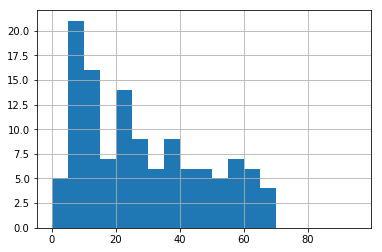

In [30]:
# Ontario % foreign born - ridings
ont_master_df['pctforeignborn'].hist(bins=range(0,100,5))

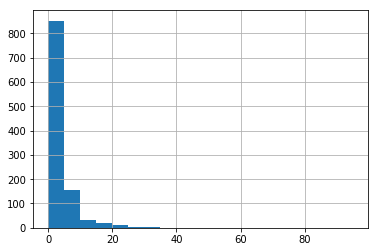

In [31]:
# US % foreign born - counties
us_dataset['pctforeignborn'].hist(bins=range(0,100,5))

# Color States we Used (from basemap example fillstates.py)

C:\Users\David\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\David\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


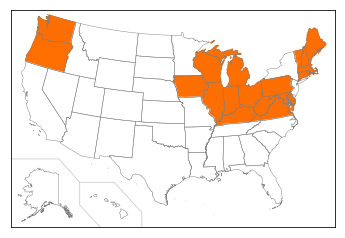

In [32]:
from __future__ import (absolute_import, division, print_function)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase

fig, ax = plt.subplots()


# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# Mercator projection, for Alaska and Hawaii
m_ = Basemap(llcrnrlon=-190,llcrnrlat=20,urcrnrlon=-143,urcrnrlat=46,
            projection='merc',lat_ts=20)  # do not change these numbers

#%% ---------   draw state boundaries  ----------------------------------------
## data from U.S Census Bureau
## http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)

## population density by state from
## http://en.wikipedia.org/wiki/List_of_U.S._states_by_population_density
popdensity = {
'New Jersey':  0,
'Rhode Island':   100,
'Massachusetts':   100,
'Connecticut':	  100,
'Maryland':   100,
'New York':   0,
'Delaware':    100,
'Florida':     0,
'Ohio':	 100,
'Pennsylvania':	 100,
'Illinois':    100,
'California':  0,
'Hawaii':  0,
'Virginia':    100,
'Michigan':    100,
'Indiana':    100,
'North Carolina':  0,
'Georgia':     0,
'Tennessee':   0,
'New Hampshire':   100,
'South Carolina':  0,
'Louisiana':   0,
'Kentucky':   100,
'Wisconsin':  100,
'Washington':  100,
'Alabama':     0,
'Missouri':    0,
'Texas':   0,
'West Virginia':   100,
'Vermont':     100,
'Minnesota':  0,
'Mississippi':	 0,
'Iowa':	 100,
'Arkansas':    0,
'Oklahoma':    0,
'Arizona':     0,
'Colorado':    0,
'Maine':  100,
'Oregon':  100,
'Kansas':  0,
'Utah':	 0,
'Nebraska':    0,
'Nevada':  0,
'Idaho':   0,
'New Mexico':  0,
'South Dakota':	 0,
'North Dakota':	 0,
'Montana':     0,
'Wyoming':      0,
'Alaska':     0}

#%% -------- choose a color for each state based on population density. -------
colors={}
statenames=[]
cmap = plt.cm.hot_r # use 'reversed hot' colormap
vmin = 0; vmax = 450 # set range.
norm = Normalize(vmin=vmin, vmax=vmax)
for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = popdensity[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)

#%% ---------  cycle through state names, color each one.  --------------------
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
        color = rgb2hex(colors[statenames[nshape]])
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)

AREA_1 = 0.005  # exclude small Hawaiian islands that are smaller than AREA_1
AREA_2 = AREA_1 * 30.0  # exclude Alaskan islands that are smaller than AREA_2
AK_SCALE = 0.19  # scale down Alaska to show as a map inset
HI_OFFSET_X = -1900000  # X coordinate offset amount to move Hawaii "beneath" Texas
HI_OFFSET_Y = 250000    # similar to above: Y offset for Hawaii
AK_OFFSET_X = -250000   # X offset for Alaska (These four values are obtained
AK_OFFSET_Y = -750000   # via manual trial and error, thus changing them is not recommended.)

for nshape, shapedict in enumerate(m_.states_info):  # plot Alaska and Hawaii as map insets
    if shapedict['NAME'] in ['Alaska', 'Hawaii']:
        seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
        if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > AREA_1:
            seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
            color = rgb2hex(colors[statenames[nshape]])
        elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > AREA_2:
            seg = [(x*AK_SCALE + AK_OFFSET_X, y*AK_SCALE + AK_OFFSET_Y)\
                   for x, y in seg]
            color = rgb2hex(colors[statenames[nshape]])
        poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
        ax.add_patch(poly)



#%% ---------  Plot bounding boxes for Alaska and Hawaii insets  --------------
light_gray = [0.8]*3  # define light gray color RGB
x1,y1 = m_([-190,-183,-180,-180,-175,-171,-171],[29,29,26,26,26,22,20])
x2,y2 = m_([-180,-180,-177],[26,23,20])  # these numbers are fine-tuned manually
m_.plot(x1,y1,color=light_gray,linewidth=0.8)  # do not change them drastically
m_.plot(x2,y2,color=light_gray,linewidth=0.8)


plt.show()
